In [1]:
%matplotlib inline
import networkx as nx
import metis
import pandas as pd
from collections import defaultdict
from datetime import timedelta, datetime
from tqdm import tqdm

from rwc import controversy_score
from util import tw_list, get_cut_ratio
from leopard import update_partition


In [2]:
retweets = pd.read_pickle('data/july.pkl')

In [3]:
retweets.sort_values(by=['created_at'], axis='index', inplace=True)

In [4]:
debug = False
top_edge_percent=0.01



In [15]:
tag2log = defaultdict(lambda: defaultdict(list))
tag2g = defaultdict(nx.Graph)
tag2edge_list = defaultdict(tw_list)
tag2edges_rm = defaultdict(list)
tag2edges_add = defaultdict(list)
T_window = timedelta(minutes=5)

update_interval = timedelta(minutes=1)
last_updated_time = retweets.iloc[0]['created_at']

for i, rt in tqdm(retweets.head(int(1e5)).iterrows()):
    if i % 5000 == 0:
        print('#hashtags {}'.format(len(tag2g)))
        print('now {}'.format(rt['created_at']))
        
    hashtag = rt['hashtag']
    g = tag2g[hashtag]  
    edge_list = tag2edge_list[hashtag]
    
    u, v, now = rt['retweeter'], rt['retweetee'], rt['created_at']

    tag2edges_add[hashtag].append((u, v))
    
    # remove expired edges by triggered hashtag or do it periodically?
    earlist_time = now - T_window
    edges_to_remove = edge_list.remove_before_time(earlist_time)
    if edges_to_remove:
        tag2edges_rm[hashtag] += edges_to_remove
    
    g.graph['updated'] = False

    if now - last_updated_time > update_interval:
        for h, g in tag2g.items():
            def print_log():
                print('calculating {}'.format(h))
                print('add {} edges'.format(len(edges_to_add)))
                print('rm {} edges'.format(len(edges_to_rm)))                
                        
            updated = False
            if not g.graph['updated']:
                # update
                edges_to_add = tag2edges_add[h]
                edges_to_rm = tag2edges_rm[h]

                # empty it
                tag2edges_add[h] = []
                tag2edges_rm[h] = []
                
                pr_vects = g.graph.get('pagerank_vectors')
                if not pr_vects:  # 1st time                    
                    g.add_edges_from(edges_to_add)
                    g.remove_edges_from(edges_to_rm)
                    if g.number_of_nodes() > 100:  # only calculate RWC when the graph is big enough
                        if debug:
                            print_log()
                        cuts, node_cluster_ids = metis.part_graph(g, 2)
                        rwc, aux = controversy_score(g, node_cluster_ids, top_percent=top_edge_percent)
                        updated = True
                else:  # incremental
                    if debug:
                        print('updating')
                        print_log()
                    node_cluster_ids = g.graph['node_cluster_ids']
                    node_cluster_ids = update_partition(g, node_cluster_ids,
                                                        edges_to_add=edges_to_add,
                                                        edges_to_remove=edges_to_rm,                                                         
                                                        verbose=False)
                    pr0 = {n: pr_vects['pr0'].get(n, 0) for n in g.nodes_iter()}
                    pr1 = {n: pr_vects['pr1'].get(n, 0) for n in g.nodes_iter()}
                    rwc, aux = controversy_score(g, node_cluster_ids,
                                                 top_percent=top_edge_percent,
                                                 nstart0=pr0,
                                                 nstart1=pr1)
                    updated = True
                    
                if updated:                    
                    g.graph['node_cluster_ids'] = node_cluster_ids
                    g.graph['pagerank_vectors'] = {'pr0': aux['pr0'], 'pr1': aux['pr1']}
                    g.graph['rwc'] = rwc
                    g.graph['updated'] = True

                    tag2log[h]['rwc'].append(rwc)
                    tag2log[h]['graph_size'].append(g.number_of_nodes())
                    tag2log[h]['cut_ratio'].append(get_cut_ratio(g, node_cluster_ids))
                    tag2log[h]['time'].append(now)
                    
        last_updated_time = now  # TODO: now should be changed
    
    # filter out non-controversial hashtags
    
    # top-k hashtag update
    


0it [00:00, ?it/s]
1it [00:00,  1.20it/s]
134it [00:01,  1.72it/s]
388it [00:01,  2.45it/s]
644it [00:01,  3.51it/s]
901it [00:01,  5.00it/s]
1149it [00:01,  7.14it/s]

#hashtags 491
now 2016-07-03 06:35:02.665000



1395it [00:01, 10.19it/s]
1607it [00:01, 14.52it/s]
1803it [00:01, 20.66it/s]
1989it [00:01, 29.38it/s]
2175it [00:01, 41.67it/s]
2357it [00:02, 58.53it/s]
2516it [00:02, 82.10it/s]
2668it [00:02, 114.16it/s]
2813it [00:02, 156.46it/s]
2950it [00:02, 209.73it/s]
3118it [00:02, 281.68it/s]
3311it [00:02, 378.67it/s]
3461it [00:03, 472.29it/s]
3599it [00:03, 562.17it/s]
3726it [00:03, 642.52it/s]
3844it [00:03, 655.38it/s]
3950it [00:03, 613.32it/s]
4084it [00:03, 699.76it/s]
4234it [00:04, 671.45it/s]
4382it [00:04, 681.23it/s]
4508it [00:04, 659.30it/s]
4664it [00:04, 587.69it/s]
4783it [00:04, 645.38it/s]
4914it [00:05, 759.76it/s]
5090it [00:05, 815.93it/s]
5225it [00:05, 754.54it/s]
5355it [00:05, 705.25it/s]
5472it [00:05, 686.20it/s]
5615it [00:05, 705.60it/s]
5756it [00:06, 721.31it/s]
5870it [00:06, 751.33it/s]
5979it [00:06, 622.54it/s]
6119it [00:06, 649.68it/s]
6259it [00:07, 590.80it/s]
6394it [00:07, 538.98it/s]
6540it [00:07, 465.07it/s]
6665it [00:08, 433.62it/s]
Excepti

#hashtags 3562
now 2016-07-03 07:30:02.659000


10451it [00:15, 506.18it/s]

#hashtags 4209
now 2016-07-03 07:44:39.664000


15336it [00:27, 373.41it/s]

#hashtags 5829
now 2016-07-03 08:19:07.658000


23457it [00:53, 264.09it/s]

#hashtags 7982
now 2016-07-03 09:11:34.660000


27022it [01:06, 244.68it/s]

#hashtags 8918
now 2016-07-03 09:38:21.666000


32199it [01:28, 210.11it/s]

#hashtags 10202
now 2016-07-03 10:16:17.665000


35342it [01:42, 188.96it/s]

#hashtags 11027
now 2016-07-03 10:41:00.665000


43374it [02:23, 163.67it/s]

#hashtags 13140
now 2016-07-03 11:39:39.659000


44185it [02:28, 135.31it/s]

#hashtags 13323
now 2016-07-03 11:44:44.666000


49786it [03:05, 126.69it/s]

#hashtags 14726
now 2016-07-03 12:22:40.663000


51042it [03:14, 120.36it/s]

#hashtags 15043
now 2016-07-03 12:31:05.659000


61758it [04:23, 168.17it/s]

#hashtags 17472
now 2016-07-03 13:34:51.661000


61930it [04:24, 159.89it/s]

#hashtags 17501
now 2016-07-03 13:35:34.666000


75841it [06:03, 141.91it/s]

#hashtags 20359
now 2016-07-03 14:43:45.663000


76585it [06:08, 154.27it/s]

#hashtags 20459
now 2016-07-03 14:46:25.659000


78206it [06:21, 121.37it/s]

#hashtags 20812
now 2016-07-03 14:54:31.665000


86953it [07:33, 91.72it/s]

#hashtags 22373
now 2016-07-03 15:32:16.657000


88607it [07:46, 122.46it/s]

#hashtags 22720
now 2016-07-03 15:39:35.666000


97336it [09:00, 162.01it/s]

#hashtags 24301
now 2016-07-03 16:15:25.666000


100000it [09:32, 174.65it/s]


In [16]:
hottest_h = max(tag2g, key=lambda k: tag2g[k].number_of_nodes())

In [17]:
g = tag2g[hottest_h]
log = tag2log[hottest_h]

In [18]:
df = pd.DataFrame.from_dict(log)

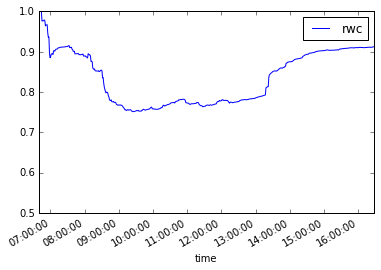

In [19]:
df.plot(x='time', y='rwc', ylim=[0.5, 1])

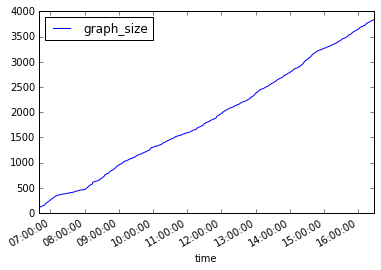

In [20]:
df.plot(x='time', y='graph_size')

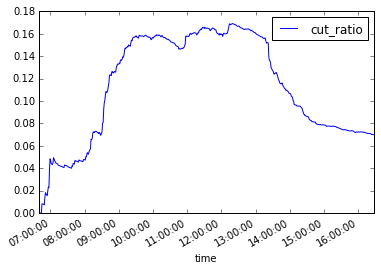

In [21]:
df.plot(x='time', y='cut_ratio')